In [2]:
import xgboost
import sys; sys.path.insert(0,"/projects/leelab3/hughchen/shap")
import shap
import matplotlib.pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import roc_auc_score, average_precision_score
import argparse
# from feature_selector import FeatureSelector
from sklearn.model_selection import GridSearchCV
import pickle
# from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines.utils import concordance_index
from tqdm import tqdm
import math
import seaborn as sns
from matplotlib.patches import PathPatch

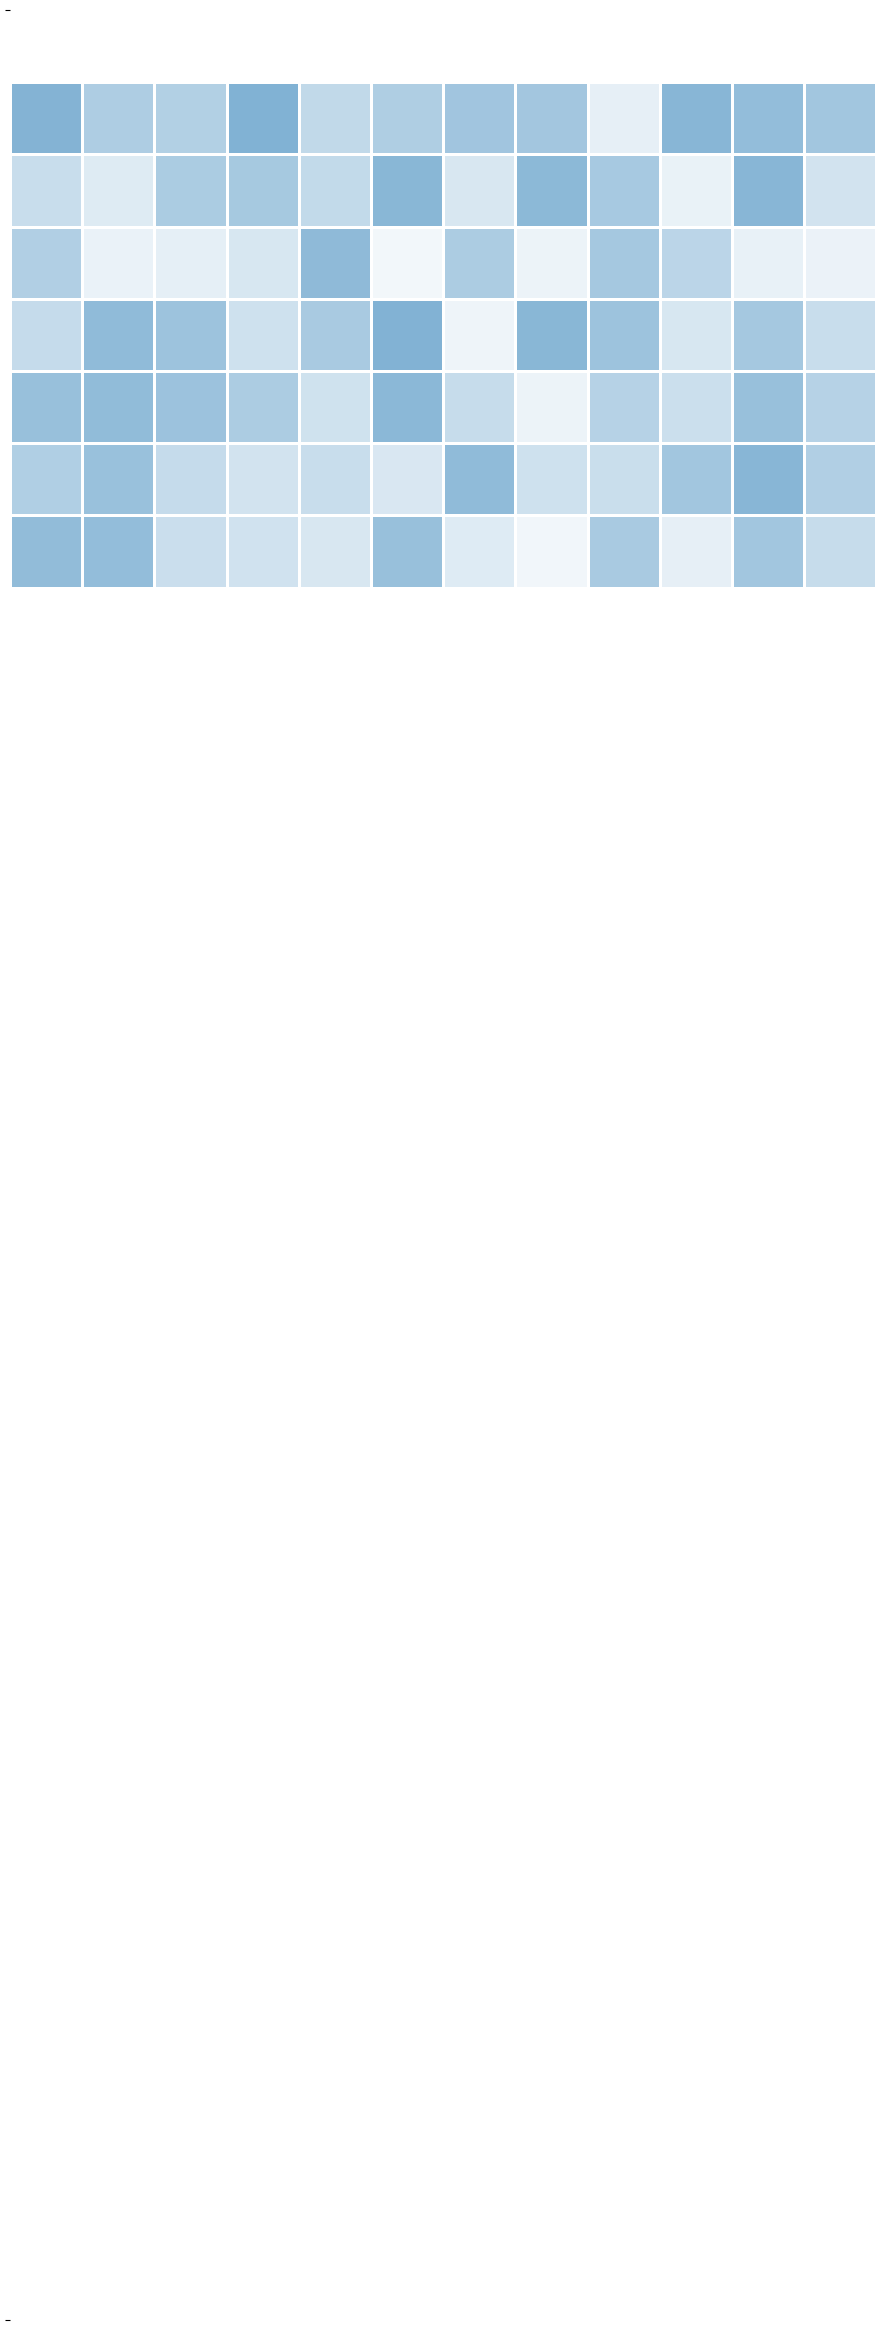

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import pickle

cmap = LinearSegmentedColormap.from_list('mycmap', ['#FFFFFF', '#80b1d3'])
plt.figure(figsize=(20, 30))
random_values = np.random.rand(7, 12)
cm = sns.heatmap(random_values,
                   linecolor = 'White', linewidths = 1,
                   vmin = -0.1, vmax = 1.0,
                    cmap = cmap,
                    annot = False, cbar = False)
plt.xticks([])
plt.yticks([-1, 31])
plt.gca().set_aspect('equal')
plt.savefig('./result/paper_figures/feature_heatmap.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
list(display_name.loc[display_name['Type_Short_Name']==col, 'Display_Name'])[0]

In [2]:
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [16]:
ukb_cox_cindex = pickle.load(open('ukb_cox_cindex.pkl', 'rb'))
ukb_cox_cindex_linear = pickle.load(open('ukb_cox_cindex_linear.pkl', 'rb'))
ukb_cox_cindex_top20 = pickle.load(open('ukb_cox_cindex_top20.pkl', 'rb'))

In [17]:
alpha = 0.05
task = ['all-cause', 'neoplasms', 'circulatory']
task_dict = {'all-cause': 'All-cause', 'neoplasms': 'Neoplasms-\ncause',
             'circulatory':'Circulatory\ndisease-cause'}

linear_bincenters = []
linear_left_error = []
linear_right_error = []
for t in task:
    linear_bincenters.append(np.mean(ukb_cox_cindex_linear['linear'][t]['res']))
    linear_left_error.append(np.mean(ukb_cox_cindex_linear['linear'][t]['res'])-np.percentile(ukb_cox_cindex_linear['linear'][t]['res'], alpha/2*100))
    linear_right_error.append(np.percentile(ukb_cox_cindex_linear['linear'][t]['res'], 100-alpha/2*100)-np.mean(ukb_cox_cindex_linear['linear'][t]['res']))
    
    linear_bincenters.append(np.mean(ukb_cox_cindex_linear['linear'][t]['res_geo']))
    linear_left_error.append(np.mean(ukb_cox_cindex_linear['linear'][t]['res_geo'])-np.percentile(ukb_cox_cindex_linear['linear'][t]['res_geo'], alpha/2*100))
    linear_right_error.append(np.percentile(ukb_cox_cindex_linear['linear'][t]['res_geo'], 100-alpha/2*100)-np.mean(ukb_cox_cindex_linear['linear'][t]['res_geo']))

xgboost_bincenters = []
xgboost_left_error = []
xgboost_right_error = []
for t in task:
    xgboost_bincenters.append(np.mean(ukb_cox_cindex['xgboost'][t]['res']))
    xgboost_left_error.append(np.mean(ukb_cox_cindex['xgboost'][t]['res'])-np.percentile(ukb_cox_cindex['xgboost'][t]['res'], alpha/2*100))
    xgboost_right_error.append(np.percentile(ukb_cox_cindex['xgboost'][t]['res'], 100-alpha/2*100)-np.mean(ukb_cox_cindex['xgboost'][t]['res']))
    
    xgboost_bincenters.append(np.mean(ukb_cox_cindex['xgboost'][t]['res_geo']))
    xgboost_left_error.append(np.mean(ukb_cox_cindex['xgboost'][t]['res_geo'])-np.percentile(ukb_cox_cindex['xgboost'][t]['res_geo'], alpha/2*100))
    xgboost_right_error.append(np.percentile(ukb_cox_cindex['xgboost'][t]['res_geo'], 100-alpha/2*100)-np.mean(ukb_cox_cindex['xgboost'][t]['res_geo']))

top20_bincenters = []
top20_left_error = []
top20_right_error = []
for t in task:
    top20_bincenters.append(np.mean(ukb_cox_cindex_top20['top20'][t]['res']))
    top20_left_error.append(np.mean(ukb_cox_cindex_top20['top20'][t]['res'])-np.percentile(ukb_cox_cindex_top20['top20'][t]['res'], alpha/2*100))
    top20_right_error.append(np.percentile(ukb_cox_cindex_top20['top20'][t]['res'], 100-alpha/2*100)-np.mean(ukb_cox_cindex_top20['top20'][t]['res']))

    top20_bincenters.append(np.mean(ukb_cox_cindex_top20['top20'][t]['res_geo']))
    top20_left_error.append(np.mean(ukb_cox_cindex_top20['top20'][t]['res_geo'])-np.percentile(ukb_cox_cindex_top20['top20'][t]['res_geo'], alpha/2*100))
    top20_right_error.append(np.percentile(ukb_cox_cindex_top20['top20'][t]['res_geo'], 100-alpha/2*100)-np.mean(ukb_cox_cindex_top20['top20'][t]['res_geo']))

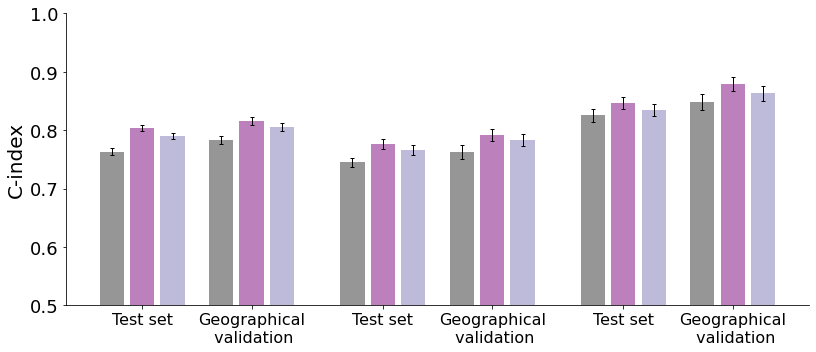

In [18]:
fontsize=18
# labels = [task_dict[t] for t in task]+[task_dict[t] for t in task]
labels = ['Test set', 'Geographical\n validation', 'Test set', 'Geographical\n validation', 'Test set', 'Geographical\n validation']

gap = 0.2
# x = np.arange(len(labels))   # the label locations

x = np.array([0, 1, 2+gap, 3+gap, 4+2*gap, 5+2*gap]) * 0.9
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(11.5, 5))
rects1 = ax.bar(x - 0.25, linear_bincenters, width, yerr=[linear_left_error,linear_right_error], error_kw=dict(lw=1, capsize=2, capthick=1),
                color='#969696', label='Linear')
rects2 = ax.bar(x, xgboost_bincenters, width, yerr=[xgboost_left_error,xgboost_right_error], error_kw=dict(lw=1, capsize=2, capthick=1),
                color='#bc80bd', label='XGBoost')
rects3 = ax.bar(x + 0.25, top20_bincenters, width, yerr=[top20_left_error,top20_right_error], error_kw=dict(lw=1, capsize=2, capthick=1), 
                color='#bebada', label='XGBoost\n(top20)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('C-index', fontsize=fontsize+2)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=fontsize-2)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
# ax.legend(fontsize=fontsize, bbox_to_anchor=(1, 0.4))
ax.set_ylim(0.5, 1)
plt.subplots_adjust(right=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.tight_layout()
plt.savefig('./result/paper_figures/UKB_AUROC_barplot.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

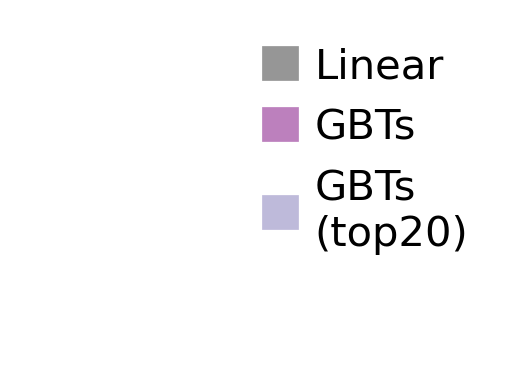

In [203]:
color_mapper = {
    'Linear': '#969696',
    'GBTs': '#bc80bd', 
    'GBTs\n(top20)': '#bebada', 
}
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=5) for c in list(color_mapper.values())]
ax = plt.subplot()  #create the axes 
ax.set_axis_off()  #turn off the axis 
num_cols = int(np.ceil((len(color_mapper.keys()) + 1)/100))
num_cols=1

# ax.legend(custom_lines,  list(color_mapper.keys()), frameon=False, ncol=num_cols, prop={'size': 20})
handles, labels = plt.gca().get_legend_handles_labels()
custom_lines = [Line2D([0], [0], color=c, lw=25) for c in list(color_mapper.values())]
plt.legend(custom_lines,
           list(color_mapper.keys()), #ncol=len(color_mapper.keys()),
           handlelength=0.065, handleheight=0.8, frameon=False, prop={'size': 30})
plt.savefig('./result/paper_figures/AUROC_barplot_legend.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show() 

In [12]:
nhanes_cox_cindex = pickle.load(open('./NHANES/bootstrap_nhanes_cox_cindex.pkl', 'rb'))
nhanes_cox_cindex_linear = pickle.load(open('./NHANES/bootstrap_nhanes_cox_cindex_linear.pkl', 'rb'))
nhanes_cox_cindex_top20 = pickle.load(open('./NHANES/bootstrap_nhanes_cox_cindex_top20.pkl', 'rb'))

In [13]:
alpha = 0.05
task = ['all-cause', '2', '1', ]
task_dict = {'all-cause': 'All-cause', '2': 'Malignant\nneoplasm-cause',
             '1':'Diseases of\nheart-cause'}

linear_bincenters = []
linear_left_error = []
linear_right_error = []
for t in task:
    linear_bincenters.append(np.mean(nhanes_cox_cindex_linear['linear'][t]['res']))
    linear_left_error.append(np.mean(nhanes_cox_cindex_linear['linear'][t]['res'])-np.percentile(nhanes_cox_cindex_linear['linear'][t]['res'], alpha/2*100))
    linear_right_error.append(np.percentile(nhanes_cox_cindex_linear['linear'][t]['res'], 100-alpha/2*100)-np.mean(nhanes_cox_cindex_linear['linear'][t]['res']))

xgboost_bincenters = []
xgboost_left_error = []
xgboost_right_error = []
for t in task:
    xgboost_bincenters.append(np.mean(nhanes_cox_cindex['xgboost'][t]['res']))
    xgboost_left_error.append(np.mean(nhanes_cox_cindex['xgboost'][t]['res'])-np.percentile(nhanes_cox_cindex['xgboost'][t]['res'], alpha/2*100))
    xgboost_right_error.append(np.percentile(nhanes_cox_cindex['xgboost'][t]['res'], 100-alpha/2*100)-np.mean(nhanes_cox_cindex['xgboost'][t]['res']))

top20_bincenters = []
top20_left_error = []
top20_right_error = []
for t in task:
    top20_bincenters.append(np.mean(nhanes_cox_cindex_top20['top20'][t]['res']))
    top20_left_error.append(np.mean(nhanes_cox_cindex_top20['top20'][t]['res'])-np.percentile(nhanes_cox_cindex_top20['top20'][t]['res'], alpha/2*100))
    top20_right_error.append(np.percentile(nhanes_cox_cindex_top20['top20'][t]['res'], 100-alpha/2*100)-np.mean(nhanes_cox_cindex_top20['top20'][t]['res']))

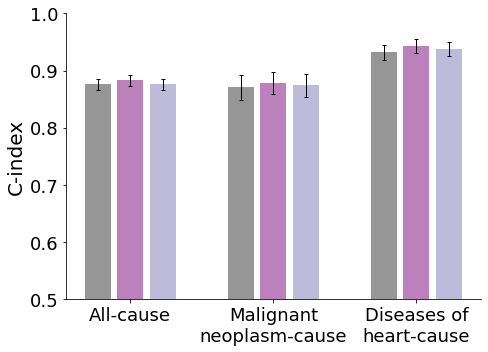

In [15]:
fontsize=18
labels = [task_dict[t] for t in task]

x = np.arange(len(labels))*1.1  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(7, 5))
rects1 = ax.bar(x - 0.25, linear_bincenters, width, yerr=[linear_left_error,linear_right_error], error_kw=dict(lw=1, capsize=2, capthick=1),
                color='#969696', label='Linear')
rects2 = ax.bar(x, xgboost_bincenters, width, yerr=[xgboost_left_error,xgboost_right_error], error_kw=dict(lw=1, capsize=2, capthick=1),
                color='#bc80bd', label='XGBoost')
rects3 = ax.bar(x + 0.25, top20_bincenters, width, yerr=[top20_left_error,top20_right_error], error_kw=dict(lw=1, capsize=2, capthick=1), 
                color='#bebada', label='XGBoost\n(top20)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('C-index', fontsize=fontsize+2)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
# ax.legend(fontsize=fontsize, bbox_to_anchor=(1, 0.4))
ax.set_ylim(0.5, 1)
plt.subplots_adjust(right=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.tight_layout()
plt.savefig('./result/paper_figures/NHANES_AUROC_barplot.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [308]:
mortality = 'all-cause'

path = './result/IMPACT_Age_missforest/XGB_Cox'+'_'+mortality
path += '_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/'
age_feature = 'Age'

fore_data = pd.read_csv(path+'fore_data.csv')

file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in fore_data.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

shap_values = np.load(path+'shap_values.npy')
shap.summary_plot(shap_values, fore_data, feature_names=display_col, show=False)

FileNotFoundError: [Errno 2] No such file or directory: './result/IMPACT_Age_missforest/XGB_Cox_all-cause_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/shap_values.npy'

In [8]:
feature_sorted = fore_data.columns[np.argsort(-np.sum(np.abs(shap_values), axis=0))]
for i in range(50):
    print(i,feature_sorted[i], col_dict[feature_sorted[i]])

0 Age Age
1 20161-0.0 Pack years of smoking
2 40008-0.0_1 Age at cancer diagnosis (last)
3 1249-0.0 Past tobacco smoking
4 30720-0.0 Cystatin C
5 2453-0.0 Cancer diagnosed by doctor
6 30070-0.0 Red blood cell (erythrocyte) distribution width
7 30160-0.0 Basophill count
8 30710-0.0 C-reactive protein
9 50-0.0 Standing height
10 31-0.0 Sex
11 30110-0.0 Platelet distribution width
12 2188-0.0 Long-standing illness, disability or infirmity
13 30500-0.0 Microalbumin in urine
14 134-0.0 Number of self-reported cancers
15 5116-0.5 3mm cylindrical power (right) - 5
16 6141-0.0_2 How are people in household related to participant - Son and/or daughter (include step-children)
17 30620-0.0 Alanine aminotransferase
18 30830-0.0 SHBG
19 30010-0.0 Red blood cell (erythrocyte) count
20 4198-0.0 Position of the pulse wave peak
21 93-0.0 Systolic blood pressure, manual reading
22 5183-0.0 Current eye infection
23 2897-0.0 Age stopped smoking
24 6145-0.0_1 Illness, injury, bereavement, stress in last 2 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


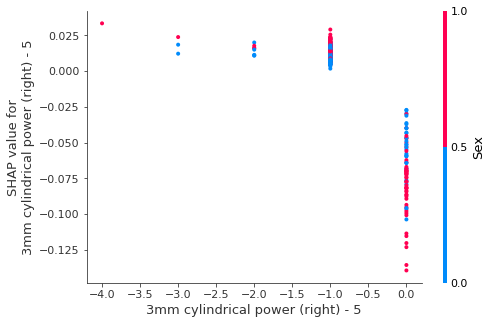

In [9]:
feature = '5116-0.5'
shap.dependence_plot(col_dict[feature], shap_values, fore_data, feature_names=display_col, show=True)

In [3]:
def convert_shap_values_SameAge(shap_age_obj, shap_values_all_dict, fore_prediction, back_prediction):
    print('Starting converting SHAP values')
    fore_attr_defa = shap_values_all_dict.mean(2)
    fore_attr_per_ref = shap_values_all_dict
    fore_attr_per_ref = np.swapaxes(fore_attr_per_ref,1,2)                           # Re-order axes 
    fore_lodd_pred = fore_prediction
    back_lodd_pred = back_prediction

    fore_func_pred = shap_age_obj.get_shap_age(fore_lodd_pred)
    back_func_pred = shap_age_obj.get_shap_age(back_lodd_pred)
    fore_shap_age = fore_func_pred
    back_shap_age = back_func_pred
    # Get the factor by which we rescale the per back_data_temp attributions
    denom    = fore_lodd_pred[:,None] - back_lodd_pred[None,:]
    numer    = fore_func_pred[:,None] - back_func_pred[None,:]
    safe_div = lambda a,b : np.divide(a, b, out=np.zeros_like(a), where=b!=0) # Divide by zero gives zero
    rescale  = safe_div(numer, denom)        # Rescale factor based on func_lodds
    # Do the final rescaling
    final_attr = fore_attr_per_ref * rescale[:,:,None] # The final, rescaled attribution
    fore_final_attr = final_attr.mean(1)
    return fore_final_attr

In [ ]:
age = 65
gender = 'female'
gender_index = 0
age_feature = 'Age'
gender_feature = '31-0.0'
mortality = 'neoplasms'
path_age = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+t+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/'
model_train = pickle.load(open(path_age+'/model.pickle.dat', "rb"))
shap_age_obj = pickle.load(open(path_age+'/different_age_background/'+gender+'/SHAP_age_exponential/shap_age_object.pkl', "rb"))
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/'
shap_values_original = np.load(path+'shap_values_single_'+mortality+'_'+gender+'_'+str(age)+'_1000.npy')
X_back = pd.read_csv(path+'X_back'+'_'+gender+'_'+str(age)+'_4000.csv')[model_train.get_booster().feature_names]
X_fore = pd.read_csv(path+'X_fore'+'_'+gender+'_'+str(age)+'_1000.csv')[model_train.get_booster().feature_names]
mortality_pre_back = model_train.predict(X_back, output_margin=True)
mortality_pre_fore = model_train.predict(X_fore, output_margin=True)
shap_values_rescaled = convert_shap_values_SameAge(shap_age_obj, shap_values_original, mortality_pre_fore, mortality_pre_back)

In [ ]:
file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in X_fore.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

In [ ]:
X_fore_display = X_fore.replace(-1, np.nan)

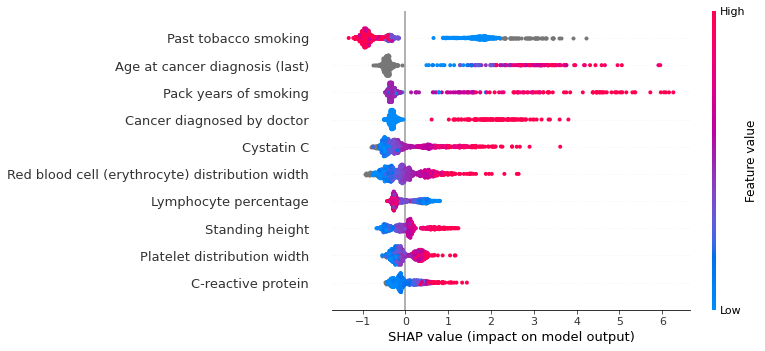

In [23]:
shap.summary_plot(shap_values_rescaled, X_fore_display, max_display=10, feature_names=display_col, show=False)
plt.savefig('./result/paper_figures/UKB_EXPECT_age_summary_plot_'+mortality+'.pdf', format='pdf', bbox_inches='tight')

In [8]:
mortality = 'all-cause'
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+mortality+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/'
model_train = pickle.load(open(path+'/model.pickle.dat', "rb"))
X_back = pd.read_csv(path+'back_data.csv')#[model_train.get_booster().feature_names]
X_fore = pd.read_csv(path+'fore_data.csv')#[model_train.get_booster().feature_names]
shap_values = np.load(path+'shap_values.npy')

In [9]:
file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in X_fore.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

In [10]:
X_fore_display = X_fore.replace(-1, np.nan)

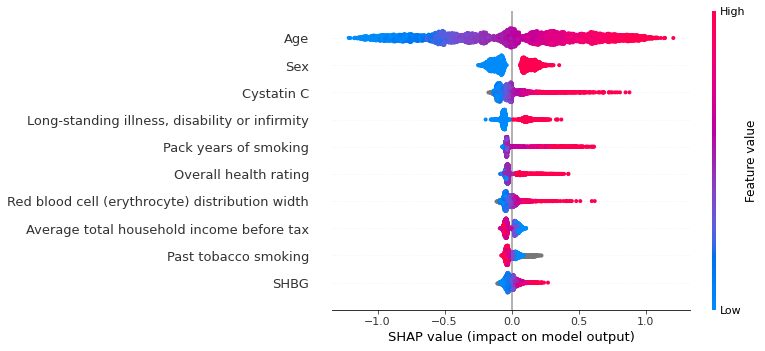

In [11]:
shap.summary_plot(shap_values, X_fore_display, max_display=10, feature_names=display_col, show=False)
plt.savefig('./result/paper_figures/UKB_original_age_65_summary_plot_'+mortality+'.pdf', format='pdf', bbox_inches='tight')

# Fitting plot

In [131]:
dataset = 'biobank'
mortality = 'all-cause'
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+mortality
path += '_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation'
age_feature = 'Age'

model_path = path+'/model.pickle.dat'
model_train = pickle.load(open(model_path, "rb"))

back_data_female = pd.read_csv(path+'/different_age_background/female/back_data.csv')
back_data_male = pd.read_csv(path+'/different_age_background/male/back_data.csv')
shap_age_obj_female = pickle.load(open(path+'/different_age_background/'+'female'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
shap_age_obj_male = pickle.load(open(path+'/different_age_background/'+'male'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))

In [132]:
back_prediction = list(model_train.predict(back_data_female, output_margin=True)) + list(model_train.predict(back_data_male, output_margin=True))
# expected_value_list_long = np.arange(np.min(back_prediction), np.max(back_prediction), 0.1)
expected_value_list_long = np.arange(np.min(back_prediction), 4, 0.1)

color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


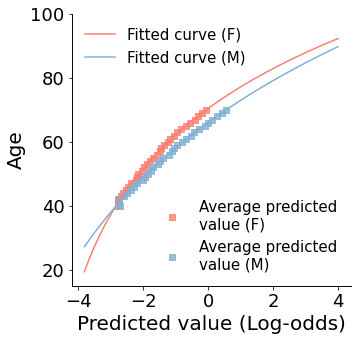

In [133]:
fontsize = 18
yvals_female = [shap_age_obj_female.get_shap_age(x) for x in expected_value_list_long]
yvals_male = [shap_age_obj_male.get_shap_age(x) for x in expected_value_list_long]
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
X = np.linspace(0,1,1000)
Y = np.cos(X*20)
ax1.plot(shap_age_obj_female.expected_value_list, shap_age_obj_female.age_list, 's', color='#fb8072', alpha=0.8, label='Average predicted\nvalue (F)')
ax1.plot(shap_age_obj_male.expected_value_list, shap_age_obj_male.age_list, 's', color='#80b1d3', alpha=0.8, label='Average predicted\nvalue (M)')
ax2 = ax1.twinx()
ax2.plot(expected_value_list_long, yvals_female, 'r', color='#fb8072', label='Fitted curve (F)')
ax2.plot(expected_value_list_long, yvals_male, 'r', color='#80b1d3', label='Fitted curve (M)')
ax1.set_xlabel('Predicted value (Log-odds)', fontsize=fontsize)
ax1.set_ylabel('Age', fontsize=fontsize)
ax2.get_yaxis().set_visible(False)

ax1.xaxis.label.set_fontsize(fontsize+2)
ax1.yaxis.label.set_fontsize(fontsize+2)
ax1.tick_params(axis='both', labelsize=fontsize)
# plt.rc('axes', labelsize=fontsize)
# plt.rc('legend', fontsize=fontsize-2)
# plt.tick_params(axis='both',which='major',labelsize=fontsize)
new_tick_locations = np.array([-5, -4, -3, -2, -1, 0, 1, 2])

def tick_function(x):
    V = np.exp(x)/(1+np.exp(x))
    return ["%.2f" % z for z in V]
# plt.ylim((20, 100))
ax1.set_ylim((15, 100))
ax2.set_ylim((15, 100))
ax1.legend(loc='lower right', prop=dict(size=fontsize-3), frameon=False) #framealpha=0.5)
ax2.legend(loc='upper left', prop=dict(size=fontsize-3), frameon=False) #, framealpha=0.5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.savefig('./result/paper_figures/UKB_EXPECT_age_fitted_plot.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [134]:
fitted_pred = [np.exp(shap_age_obj_female.popt[0]*x+shap_age_obj_female.popt[1])+np.min(list(model_train.predict(back_data_female, output_margin=True)))+shap_age_obj_female.popt[2] for x in shap_age_obj_female.age_list]

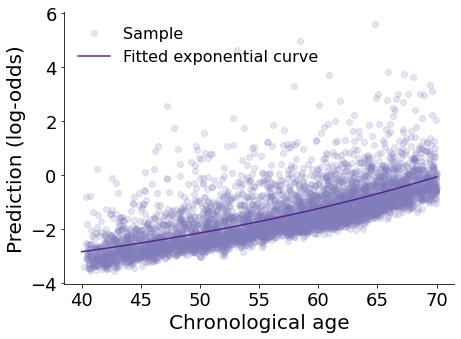

In [135]:
fontsize=18
num_sample = 5000
plt.figure(figsize=(7,5))
plt.plot(np.array(back_data_female.loc[(back_data_female[age_feature]>=40)&(back_data_female[age_feature]<=70), age_feature])[0:num_sample], 
         list(model_train.predict(back_data_female[(back_data_female[age_feature]>=40)&(back_data_female[age_feature]<=70)][0:num_sample], output_margin=True)), "o", color='#807dba', alpha=0.2, markersize=6, label='Sample')
plt.plot(shap_age_obj_female.age_list, fitted_pred, '-', color='#54278f', label='Fitted exponential curve')
plt.rc('axes', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize-2)
plt.legend(loc='best', frameon=False)
# plt.title(title+': fitting plot', fontsize=fontsize)
plt.xlabel('Chronological age', fontsize=fontsize+2)
plt.ylabel('Prediction (log-odds)', fontsize=fontsize+2)
plt.tick_params(axis='both',which='major',labelsize=fontsize)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


plt.savefig('./result/paper_figures/UKB_exp_plot_5000samples.pdf', format='pdf', bbox_inches='tight', transparent=True)
# plt.savefig('./result/UKB_exp_plot.png', format='png', bbox_inches='tight', dpi=300)
plt.show()

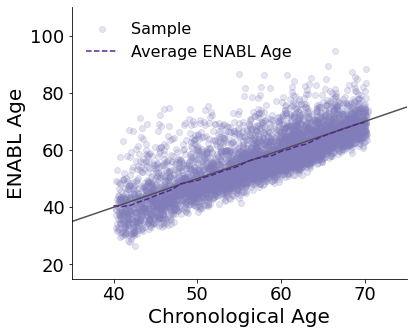

In [136]:
fore_data_female = pd.read_csv(path+'/different_age_background/female/fore_data.csv')#.sample(n=5000, random_state=7)
fore_data_male = pd.read_csv(path+'/different_age_background/male/fore_data.csv')#.sample(n=5000, random_state=7)
pre_female = model_train.predict(fore_data_female, output_margin=True)
pre_male = model_train.predict(fore_data_male, output_margin=True)
shap_age = np.array(list(shap_age_obj_female.get_shap_age(pre_female)) + list(shap_age_obj_male.get_shap_age(pre_male)))
shap_age[shap_age < 0] = 0
age_ori = np.array(list(fore_data_female[age_feature])+list(fore_data_male[age_feature]))

# mortstat = np.array(list(pd.DataFrame(np.load(path+'/different_age_background/female/mortstat_fore.npy')).sample(n=5000, random_state=7)[0])+
#            list(pd.DataFrame(np.load(path+'/different_age_background/male/mortstat_fore.npy')).sample(n=5000, random_state=7)[0]))
mortstat = np.array(list(np.load(path+'/different_age_background/female/mortstat_fore.npy'))+
           list(np.load(path+'/different_age_background/male/mortstat_fore.npy')))
p = np.random.permutation(len(age_ori))
shap_age = shap_age[p]
age_ori = age_ori[p]
mortstat = mortstat[p]
plt.figure(figsize=(6,5))
# plt.scatter(np.array(age_ori)[mortstat == 0][0:num_sample], np.array(shap_age)[mortstat == 0][0:num_sample], alpha=0.2, color='#54a0ff', label='Alive sample')
# plt.scatter(np.array(age_ori)[mortstat == 1][0:num_sample], np.array(shap_age)[mortstat == 1][0:num_sample], alpha=0.2, color='#ff6b6b', label='Deceased sample')
plt.scatter(np.array(age_ori)[0:num_sample], np.array(shap_age)[0:num_sample], alpha=0.2, color='#807dba', label='Sample')
plot1 = plt.plot(list(range(10,90)), list(range(10,90)), '#525252', linestyle="-")
# plot1 = plt.plot(list(range(10,90)), list(range(5,85)), 'gray', linestyle="--")
# plot1 = plt.plot(list(range(10,90)), list(range(15,95)), 'gray', linestyle="--")

average_shap_age = []
age_round = np.round(age_ori)
age_list = list(set(age_round))
# for a in age_list:
#     average_shap_age.append(np.mean(shap_age[(mortstat == 1) & (age_round == a)]))
for a in age_list:
    average_shap_age.append(np.mean(shap_age[(age_round == a)]))

plot2 = plt.plot(age_list, average_shap_age, '#54278f', linestyle="--", label='Average ENABL Age')

plt.ylabel('ENABL Age', fontsize=fontsize+2)
plt.xlabel('Chronological Age', fontsize=fontsize+2)
plt.tick_params(axis='both',which='major',labelsize=fontsize)
plt.xlim(35, 75)
plt.ylim(15, 110)
plt.rc('axes', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize-2)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], framealpha=False, loc='upper left') 

plt.savefig('./result/paper_figures/UKB_all_cause_SHAPAge_vs_Age_5000samples.pdf', format='pdf', bbox_inches='tight', transparent=True)
# plt.savefig('./result/UKB_all_cause_SHAPAge_vs_Age.png', format='png', bbox_inches='tight', dpi=300)

In [137]:
dataset = 'NHANES'
mortality = 'all-cause'
path = './NHANES/result/NHANES_cox_model_all-cause_retrieve_lab/'
model_path = path+'/model.pickle.dat'
model_train = pickle.load(open(model_path, "rb"))
age_feature = 'Demographics_Age'

back_data_female = pd.read_csv(path+'/different_age_background/female/back_data.csv')
back_data_male = pd.read_csv(path+'/different_age_background/male/back_data.csv')
shap_age_obj_female = pickle.load(open(path+'/different_age_background/'+'female'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
shap_age_obj_male = pickle.load(open(path+'/different_age_background/'+'male'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))

In [138]:
back_prediction = list(model_train.predict(back_data_female, output_margin=True)) + list(model_train.predict(back_data_male, output_margin=True))
expected_value_list_long = np.arange(np.min(back_prediction), np.max(back_prediction), 0.1)
expected_value_list_long = np.arange(-3.3, np.max(back_prediction), 0.1)

color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


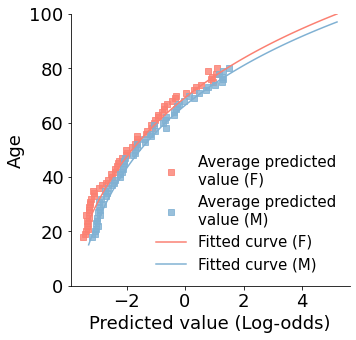

In [139]:
fontsize = 18
yvals_female = [shap_age_obj_female.get_shap_age(x) for x in expected_value_list_long]
yvals_male = [shap_age_obj_male.get_shap_age(x) for x in expected_value_list_long]
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
X = np.linspace(0,1,1000)
Y = np.cos(X*20)
ax1.plot(shap_age_obj_female.expected_value_list, shap_age_obj_female.age_list, 's', color='#fb8072', alpha=0.8, label='Average predicted\nvalue (F)')
ax1.plot(shap_age_obj_male.expected_value_list, shap_age_obj_male.age_list, 's', color='#80b1d3', alpha=0.8, label='Average predicted\nvalue (M)')
ax1.plot(expected_value_list_long, yvals_female, 'r', color='#fb8072', label='Fitted curve (F)')
ax1.plot(expected_value_list_long, yvals_male, 'r', color='#80b1d3', label='Fitted curve (M)')
ax1.set_xlabel('Predicted value (Log-odds)', fontsize=fontsize+2)
ax1.set_ylabel('Age', fontsize=fontsize+2)

ax1.xaxis.label.set_fontsize(fontsize)
ax1.yaxis.label.set_fontsize(fontsize)
ax1.tick_params(axis='both', labelsize=fontsize)
# plt.rc('axes', labelsize=fontsize)
# plt.rc('legend', fontsize=fontsize-2)
# plt.tick_params(axis='both',which='major',labelsize=fontsize)
new_tick_locations = np.array([-5, -4, -3, -2, -1, 0, 1, 2])

def tick_function(x):
    V = np.exp(x)/(1+np.exp(x))
    return ["%.2f" % z for z in V]
# plt.ylim((20, 100))
ax1.set_ylim((0, 100))
ax1.legend(loc='lower right', prop=dict(size=fontsize-3), framealpha=False)
plt.savefig('./result/paper_figures/NHANES_EXPECT_age_fitted_plot.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [140]:
fitted_pred = [np.exp(shap_age_obj_female.popt[0]*x+shap_age_obj_female.popt[1])+np.min(list(model_train.predict(back_data_female, output_margin=True)))+shap_age_obj_female.popt[2] for x in shap_age_obj_female.age_list]

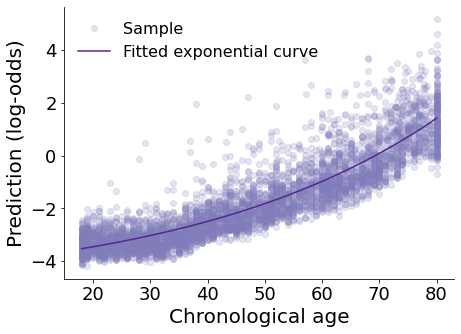

In [141]:
fontsize=18
num_sample = 5000
plt.figure(figsize=(7,5))
plt.plot(np.array(back_data_female[age_feature])[0:num_sample], 
         list(model_train.predict(back_data_female, output_margin=True))[0:num_sample], "o", color='#807dba', alpha=0.2, markersize=6, label='Sample')
plt.plot(shap_age_obj_female.age_list, fitted_pred, '-', color='#54278f', label='Fitted exponential curve')
plt.rc('axes', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize-2)
plt.legend(loc='best', framealpha=False)
# plt.title(title+': fitting plot', fontsize=fontsize)
plt.xlabel('Chronological age', fontsize=fontsize+2)
plt.ylabel('Prediction (log-odds)', fontsize=fontsize+2)
plt.tick_params(axis='both',which='major',labelsize=fontsize)
plt.savefig('./result/paper_figures/NHANES_exp_plot_5000samples.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

<Figure size 432x360 with 0 Axes>

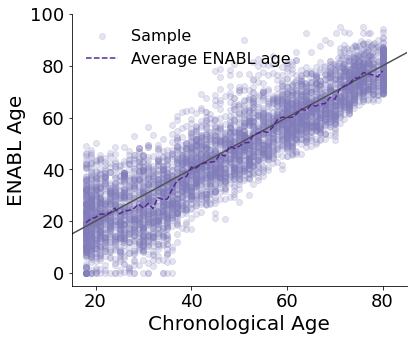

In [142]:
fore_data_female = pd.read_csv(path+'/different_age_background/female/fore_data.csv')#.sample(n=5000, random_state=7)
fore_data_male = pd.read_csv(path+'/different_age_background/male/fore_data.csv')#.sample(n=5000, random_state=7)
pre_female = model_train.predict(fore_data_female, output_margin=True)
pre_male = model_train.predict(fore_data_male, output_margin=True)
shap_age = np.array(list(shap_age_obj_female.get_shap_age(pre_female)) + list(shap_age_obj_male.get_shap_age(pre_male)))
shap_age[shap_age < 0] = 0
age_ori = np.array(list(fore_data_female[age_feature])+list(fore_data_male[age_feature]))
# mortstat = np.array(list(pd.DataFrame(np.load(path+'/different_age_background/female/mortstat_fore.npy')).sample(n=5000, random_state=7)[0])+
#            list(pd.DataFrame(np.load(path+'/different_age_background/male/mortstat_fore.npy')).sample(n=5000, random_state=7)[0]))
mortstat = np.array(list(np.load(path+'/different_age_background/female/mortstat_fore.npy'))+
           list(np.load(path+'/different_age_background/male/mortstat_fore.npy')))
p = np.random.permutation(len(age_ori))
shap_age = shap_age[p]
age_ori = age_ori[p]
mortstat = mortstat[p]
plt.figure(figsize=(6,5))
plt.figure(figsize=(6,5))
# plt.scatter(np.array(age_ori)[mortstat == 0][0:num_sample], np.array(shap_age)[mortstat == 0][0:num_sample], alpha=0.2, color='#54a0ff', label='Alive')
# plt.scatter(np.array(age_ori)[mortstat == 1][0:num_sample], np.array(shap_age)[mortstat == 1][0:num_sample], alpha=0.2, color='#ff6b6b', label='Deceased sample')
plt.scatter(np.array(age_ori)[0:num_sample], np.array(shap_age)[0:num_sample], alpha=0.2, color='#807dba', label='Sample')
plot1 = plt.plot(list(range(10,90)), list(range(10,90)), '#525252', linestyle="-")
# plot1 = plt.plot(list(range(10,90)), list(range(5,85)), 'gray', linestyle="--")
# plot1 = plt.plot(list(range(10,90)), list(range(15,95)), 'gray', linestyle="--")

average_shap_age = []
age_round = np.round(age_ori)
age_list = list(set(age_round))
# for a in age_list:
#     average_shap_age.append(np.mean(shap_age[(mortstat == 1) & (age_round == a)]))
for a in age_list:
    average_shap_age.append(np.mean(shap_age[(age_round == a)]))

plot2 = plt.plot(age_list, average_shap_age, '#54278f', linestyle="--", label='Average ENABL age')

plt.ylabel('ENABL Age', fontsize=fontsize+2)
plt.xlabel('Chronological Age', fontsize=fontsize+2)
plt.tick_params(axis='both',which='major',labelsize=fontsize)
plt.xlim(15, 85)
plt.ylim(-5, 100)
plt.rc('axes', labelsize=fontsize)
plt.rc('legend', fontsize=fontsize-2)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], framealpha=False, loc='upper left') 

plt.savefig('./result/paper_figures/NHANES_all_cause_SHAPAge_vs_Age_5000samples.pdf', format='pdf', bbox_inches='tight', transparent=True)

# Survival probability

In [143]:
def survival_probability(age_object, age, shap_age, year_num, permth_int, mortstat):  # the unit of permth_int is year
    age = np.array(age)
    shap_age = np.array(shap_age)
    age_old = age.copy()
    age = age[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))]
    shap_age = shap_age[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))]
    permth_int = permth_int[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))].reset_index(drop=True)
    mortstat = mortstat[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))].reset_index(drop=True)
    age_acc = shap_age - age
    up_value = np.quantile(age_acc, 0.75)
    down_value = np.quantile(age_acc, 0.25)
    unhealthy_index = [i for i in range(len(age)) if (age_acc[i] >= up_value)]
    healthy_index = [i for i in range(len(age)) if (age_acc[i] <= down_value)]
    print('# individuals: ', len(shap_age))
    print('# unhealthy individuals: ', len(unhealthy_index))
    print('# healthy individuals: ', len(healthy_index))
    unhealthy_surv_prob = [1]
    for i in range(1, year_num+1):
        label_temp = np.array([age_object.label(permth_int[j], mortstat[j], i) for j in unhealthy_index])
        label_temp_pre = np.array([age_object.label(permth_int[j], mortstat[j], (i-1)) for j in unhealthy_index])
        num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
        unhealthy_surv_prob.append((sum(label_temp==0)/num_samples)*unhealthy_surv_prob[-1])
#             print((sum(label_temp==0)/num_samples))
    healthy_surv_prob = [1]
    for i in range(1, year_num+1):
        label_temp = np.array([age_object.label(permth_int[j], mortstat[j], i) for j in healthy_index])
        label_temp_pre = np.array([age_object.label(permth_int[j], mortstat[j], (i-1)) for j in healthy_index])
        num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
        healthy_surv_prob.append((sum(label_temp==0)/num_samples)*healthy_surv_prob[-1])
    return healthy_surv_prob, unhealthy_surv_prob

In [144]:
def survival_probability_bootstrap(age_object, age, shap_age, year_num, permth_int, mortstat, repetitions = 1000):  # the unit of permth_int is year
    age = np.array(age)
    shap_age = np.array(shap_age)
    permth_int = np.array(permth_int)
    mortstat = np.array(mortstat)
    healthy_surv_prob_res = []
    unhealthy_surv_prob_res = []
    for i in tqdm(range(repetitions)):
        np.random.seed(i)
        idx = list(np.random.choice(len(age), replace = True, size = len(age)))
        age_bootstrap = age[idx]
        shap_age_bootstrap = shap_age[idx]
        permth_int_bootstrap = permth_int[idx]
        mortstat_bootstrap = mortstat[idx]
        healthy_surv_prob, unhealthy_surv_prob = survival_probability(age_object, age_bootstrap, shap_age_bootstrap, year_num, permth_int_bootstrap, mortstat_bootstrap)
        healthy_surv_prob_res.append(healthy_surv_prob)
        unhealthy_surv_prob_res.append(unhealthy_surv_prob)
    # # confidence interval
    # left_res = np.percentile(res, alpha/2*100)
    # right_res = np.percentile(res, 100-alpha/2*100)
    # # point estimate
    # print('average C-index: ', np.mean(res))
    # print((1-alpha)*100,'%','confidence interval for the C-index:', (round(left_res,4), round(right_res,4)))
    
    return healthy_surv_prob_res, unhealthy_surv_prob_res

In [145]:
def survival_probability(age_object, age, shap_age, year_num, permth_int, mortstat):  # the unit of permth_int is year
    age = np.array(age)
    shap_age = np.array(shap_age)
    age_old = age.copy()
    age = age[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))]
    shap_age = shap_age[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))]
    permth_int = permth_int[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))]
    mortstat = mortstat[(age_old>=min(age_object.age_list)) & (age_old<=max(age_object.age_list))]
    age_acc = shap_age - age
    up_value = np.quantile(age_acc, 0.75)
    down_value = np.quantile(age_acc, 0.25)
    unhealthy_index = [i for i in range(len(age)) if (age_acc[i] >= up_value)]
    healthy_index = [i for i in range(len(age)) if (age_acc[i] <= down_value)]
    # print('# individuals: ', len(shap_age))
    # print('# unhealthy individuals: ', len(unhealthy_index))
    # print('# healthy individuals: ', len(healthy_index))
    unhealthy_surv_prob = [1]
    for i in range(1, year_num+1):
        label_temp = np.array([age_object.label(permth_int[j], mortstat[j], i) for j in unhealthy_index])
        label_temp_pre = np.array([age_object.label(permth_int[j], mortstat[j], (i-1)) for j in unhealthy_index])
        num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
        unhealthy_surv_prob.append((sum(label_temp==0)/num_samples)*unhealthy_surv_prob[-1])
#             print((sum(label_temp==0)/num_samples))
    unhealthy_surv_prob.append(unhealthy_surv_prob[-1])
    healthy_surv_prob = [1]
    for i in range(1, year_num+1):
        label_temp = np.array([age_object.label(permth_int[j], mortstat[j], i) for j in healthy_index])
        label_temp_pre = np.array([age_object.label(permth_int[j], mortstat[j], (i-1)) for j in healthy_index])
        num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
        healthy_surv_prob.append((sum(label_temp==0)/num_samples)*healthy_surv_prob[-1])
    healthy_surv_prob.append(healthy_surv_prob[-1])
    return healthy_surv_prob, unhealthy_surv_prob

In [194]:
def survival_probability_plot(healthy_surv_prob_res, unhealthy_surv_prob_res, alpha=0.05, title='', fontsize=18, show=False, save_path=None):  # the unit of permth_int is year
    plt.figure(figsize=(6,5))
    healthy_surv_prob_res = np.array(healthy_surv_prob_res)
    unhealthy_surv_prob_res = np.array(unhealthy_surv_prob_res)
    healthy_surv_prob = np.mean(healthy_surv_prob_res, axis=0)
    healthy_surv_prob_down = np.percentile(healthy_surv_prob_res, alpha/2*100, axis=0)
    healthy_surv_prob_up = np.percentile(healthy_surv_prob_res, 100-alpha/2*100, axis=0)
    
    unhealthy_surv_prob = np.mean(unhealthy_surv_prob_res, axis=0)
    unhealthy_surv_prob_down = np.percentile(unhealthy_surv_prob_res, alpha/2*100, axis=0)
    unhealthy_surv_prob_up = np.percentile(unhealthy_surv_prob_res, 100-alpha/2*100, axis=0)
    
    plt.step([i for i in range(len(healthy_surv_prob))], healthy_surv_prob, '#54a0ff',label='Healthy agers', where="post")
    plt.step([i for i in range(len(unhealthy_surv_prob))], unhealthy_surv_prob, '#ff6b6b',label='Unhealthy agers', where="post")
    plt.fill_between([i for i in range(len(healthy_surv_prob))], healthy_surv_prob_down, healthy_surv_prob_up, step="post", color='#54a0ff', alpha=0.2)
    plt.fill_between([i for i in range(len(unhealthy_surv_prob))], unhealthy_surv_prob_down, unhealthy_surv_prob_up, step="post", color='#ff6b6b', alpha=0.2)
    plt.xlabel('Years from screening time', fontsize=fontsize+2)
    plt.ylabel('Cumulative Survival\nProbability', fontsize=fontsize+2)
    
    plt.xticks([i*2 for i in range(math.ceil(len(healthy_surv_prob)/2))])
    plt.ylim((0.74,1.01)) ## UKB
    # plt.ylim((0.60,1.01)) ## NHANES
    plt.tick_params(axis='both',which='major',labelsize=fontsize)
    plt.rc('axes', labelsize=fontsize)
    # plt.rc('legend', fontsize=fontsize)
    plt.legend(framealpha=False)
    plt.title(title, fontsize=fontsize)
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', transparent=True)
        # plt.savefig('./result/paper_figures/surv_prob_legend.pdf', format='pdf', bbox_inches='tight', transparent=True)
    if show:
        plt.show()
    return healthy_surv_prob, unhealthy_surv_prob

# UKB

In [148]:
dataset = 'UKB'
random_state = 528
mortality = 'all-cause'

path = './result/IMPACT_Age_missforest/XGB_Cox'+'_'+mortality
path += '_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation/'

age_feature = 'Age'
gender_feature = '31-0.0'

### scottish code: 11004, 11005
features = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/features_initial_preprocessing_missforest_imputed_no_missing_lancet_and_meaningful_adjusted_assays_remove20002and20004_AgeAdjusted_CancerAdjusted_geo.csv')
# label_df = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/death_label.csv')
label_df = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/death_label_new.csv')
if mortality != 'all-cause':
    data_mortality = pd.merge(features, label_df[['eid', 'alive_year', 'all-cause', mortality, 'external']], how='left', on='eid')
else:
    data_mortality = pd.merge(features, label_df[['eid', 'alive_year', 'all-cause', 'external']], how='left', on='eid')

X = data_mortality
X = X[(X[age_feature]>=39.5) & (X[age_feature]<=70.5)].reset_index(drop=True)  
X = X[(X['external']!=1)]
X = X[(X['all-cause']==0) | (X[mortality]==1)]
X_geo = X.loc[(X['54-0.0']==11004) | (X['54-0.0']==11005)].reset_index(drop=True)
X = X.loc[(X['54-0.0']!=11004) & (X['54-0.0']!=11005)].reset_index(drop=True)
mortstat = X[mortality]
permth_int = X['alive_year']
y = permth_int * (mortstat - .5)*2
X = X.drop([mortality, 'all-cause', 'external', 'alive_year', 'eid', '54-0.0', '21003-0.0'], axis=1)
mortstat_geo = X_geo[mortality]
permth_int_geo = X_geo['alive_year']
y_geo = permth_int_geo * (mortstat_geo - .5)*2
X_geo = X_geo.drop([mortality, 'all-cause', 'external', 'alive_year', 'eid', '54-0.0', '21003-0.0'], axis=1)

X = X.drop(['5088-0.9', '5089-0.9', '5111-0.5', '5116-0.5', '5119-0.5', 
                  # '5112-0.5', '5115-0.5', '5118-0.5', '5117-0.5',
#                 '5113-0.5', '5114-0.5', '5086-0.5', '5087-0.5', '5084-0.5', '5085-0.5',
#                 '5104-0.5', '5107-0.5', '5103-0.5', '5100-0.5', '5105-0.5', '5106-0.5',
#                 '5101-0.5', '5102-0.5', '5089-0.5', '5088-0.5', 
               ], axis=1)
X_geo = X_geo.drop(['5088-0.9', '5089-0.9', '5111-0.5', '5116-0.5', '5119-0.5', 
                  # '5112-0.5', '5115-0.5', '5118-0.5', '5117-0.5',
#                 '5113-0.5', '5114-0.5', '5086-0.5', '5087-0.5', '5084-0.5', '5085-0.5',
#                 '5104-0.5', '5107-0.5', '5103-0.5', '5100-0.5', '5105-0.5', '5106-0.5',
#                 '5101-0.5', '5102-0.5', '5089-0.5', '5088-0.5', 
               ], axis=1)
print(X.shape)

print(X.columns)
print(X.shape)
print('# samples: ', X.shape[0])
print('# positive samples: ', sum(mortstat==1))
print('# negative samples: ', sum(mortstat==0))
print('# features: ', X.shape[1])
print("GeoValidation set")
print('# samples: ', X_geo.shape[0])
print('# positive samples: ', sum(mortstat_geo==1))
print('# negative samples: ', sum(mortstat_geo==0))
print('# features: ', X_geo.shape[1])

model_train = pickle.load(open(path+"model.pickle.dat", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

mortstat_train, mortstat_test, permth_int_train, permth_int_test = train_test_split(mortstat, permth_int, test_size=0.2, random_state=random_state)
print(X_train.index)

fore_data = X_test[model_train.get_booster().feature_names].copy().reset_index(drop=True)
mortstat_fore = mortstat_test.copy().reset_index(drop=True)
permth_int_fore = permth_int_test.copy().reset_index(drop=True)

file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in fore_data.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)


shap_age_obj_female = pickle.load(open(path+'/different_age_background/'+'female'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
shap_age_obj_male = pickle.load(open(path+'/different_age_background/'+'male'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
############# SHAP Age v.s. Age plot #############***********************************************************************
fore_data['shap_age'] = None
fore_prediction_female = model_train.predict(fore_data.loc[fore_data[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
fore_data.loc[fore_data[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
fore_prediction_male = model_train.predict(fore_data.loc[fore_data[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
fore_data.loc[fore_data[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
fore_shap_age = fore_data['shap_age']
        
# shap_age_obj = pickle.load(open(path+'shap_age_object.pkl', 'rb'))

# ############# SHAP Age v.s. Age plot #############***********************************************************************
# fore_prediction = model_train.predict(fore_data[model_train.get_booster().feature_names], output_margin=True)
# fore_shap_age = np.array([shap_age_obj.get_shap_age(fore_prediction[i]) for i in range(len(fore_prediction))])
############# Survival probability #############***********************************************************************
year_num = 13
healthy_surv_prob_res, unhealthy_surv_prob_res = survival_probability_bootstrap(shap_age_obj_female, fore_data[age_feature], fore_shap_age, year_num, permth_int_fore, mortstat_fore, repetitions = 1000)#, save_path=save_path+'/survival_probability.pdf')
pickle.dump(healthy_surv_prob_res, open('./result/paper_figures/ukb_'+mortality+'_healthy_surv_prob_res.pkl', 'wb'))
pickle.dump(unhealthy_surv_prob_res, open('./result/paper_figures/ukb_'+mortality+'_unhealthy_surv_prob_res.pkl', 'wb'))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

(array([1.        , 0.99960695, 0.9989189 , 0.99795881, 0.99700872,
        0.99618753, 0.99428635, 0.99237817, 0.99091154, 0.98892929,
        0.98595407, 0.98307311, 0.97634683, 0.96444575, 0.96444575]),
 array([1.        , 0.9945548 , 0.98679824, 0.97699556, 0.96797333,
        0.9583091 , 0.94595004, 0.93465967, 0.92048119, 0.90570938,
        0.89052242, 0.87163677, 0.83631675, 0.75745039, 0.75745039]))

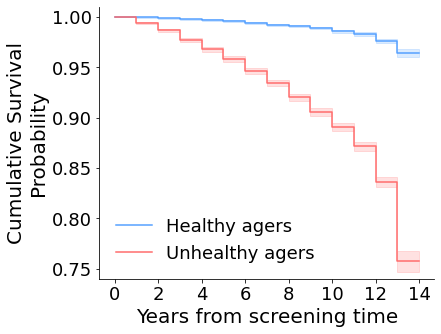

In [196]:
mortality = 'all-cause'
healthy_surv_prob_res = pickle.load(open('./result/paper_figures/ukb_'+mortality+'_healthy_surv_prob_res.pkl', 'rb'))
unhealthy_surv_prob_res = pickle.load(open('./result/paper_figures/ukb_'+mortality+'_unhealthy_surv_prob_res.pkl', 'rb'))
survival_probability_plot(healthy_surv_prob_res, unhealthy_surv_prob_res, alpha=0.05, title='', fontsize=18, show=False, save_path='./result/paper_figures/ukb_'+mortality+'_survival_probability.pdf')

In [161]:
fore_data = X_geo[model_train.get_booster().feature_names].copy().reset_index(drop=True)
mortstat_fore = mortstat_geo.copy().reset_index(drop=True)
permth_int_fore = permth_int_geo.copy().reset_index(drop=True)

file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in fore_data.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)


shap_age_obj_female = pickle.load(open(path+'/different_age_background/'+'female'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
shap_age_obj_male = pickle.load(open(path+'/different_age_background/'+'male'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
############# SHAP Age v.s. Age plot #############***********************************************************************
fore_data['shap_age'] = None
fore_prediction_female = model_train.predict(fore_data.loc[fore_data[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
fore_data.loc[fore_data[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
fore_prediction_male = model_train.predict(fore_data.loc[fore_data[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
fore_data.loc[fore_data[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
fore_shap_age = fore_data['shap_age']
        
        
# shap_age_obj = pickle.load(open(path+'shap_age_object.pkl', 'rb'))

# ############# SHAP Age v.s. Age plot #############***********************************************************************
# fore_prediction = model_train.predict(fore_data[model_train.get_booster().feature_names], output_margin=True)
# fore_shap_age = np.array([shap_age_obj.get_shap_age(fore_prediction[i]) for i in range(len(fore_prediction))])
############# Survival probability #############***********************************************************************
year_num = 13
healthy_surv_prob_res, unhealthy_surv_prob_res = survival_probability_bootstrap(shap_age_obj_female, fore_data[age_feature], fore_shap_age, year_num, permth_int_fore, mortstat_fore, repetitions = 1000)#, save_path=save_path+'/survival_probability.pdf')
pickle.dump(healthy_surv_prob_res, open('./result/paper_figures/ukb_GeoValidation_'+mortality+'_healthy_surv_prob_res.pkl', 'wb'))
pickle.dump(unhealthy_surv_prob_res, open('./result/paper_figures/ukb_GeoValidation_'+mortality+'_unhealthy_surv_prob_res.pkl', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:32<00:00,  1.53s/it]


(array([1.        , 0.9997769 , 0.99931763, 0.99833406, 0.99754396,
        0.99629899, 0.99488994, 0.99252968, 0.99034699, 0.98821694,
        0.9859698 , 0.98334249, 0.98007572, 0.97354111, 0.97354111]),
 array([1.        , 0.99351146, 0.98488035, 0.97313056, 0.96066288,
        0.94838754, 0.93546512, 0.91952812, 0.90390719, 0.88761704,
        0.86963384, 0.84826554, 0.82725755, 0.79119635, 0.79119635]))

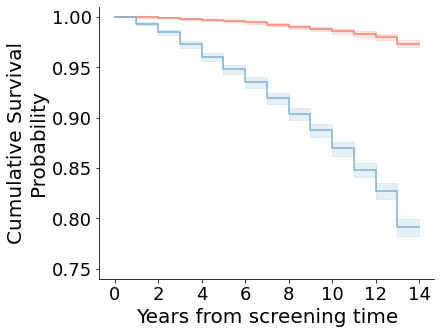

In [170]:
mortality = 'neoplasms'
healthy_surv_prob_res = pickle.load(open('./result/paper_figures/ukb_GeoValidation_'+mortality+'_healthy_surv_prob_res.pkl', 'rb'))
unhealthy_surv_prob_res = pickle.load(open('./result/paper_figures/ukb_GeoValidation_'+mortality+'_unhealthy_surv_prob_res.pkl', 'rb'))
survival_probability_plot(healthy_surv_prob_res, unhealthy_surv_prob_res, alpha=0.05, title='', fontsize=18, show=False, save_path='./result/paper_figures/ukb_'+mortality+'_GeoValidation_survival_probability.pdf')

# NHANES

In [228]:
task_dict = {'all-cause': 'all-cause', '1': 'Diseases of heart', '2': 'Malignant neoplasms', '3': 'Chronic lower respiratory diseases', '5': 'Cerebrovascular diseases', '6': 'Alzheimer’s disease', '7': 'Diabetes mellitus',  '8': 'Influenza and pneumonia', '9': 'Nephritis, nephrotic syndrome and nephrosis', '10': 'All other causes'}
dataset = 'NHANES'
cause = '2'
random_state = 7
valid = '0'
gender = 'female'
age_feature = 'Demographics_Age'
gender_feature = 'Demographics_Gender_2.0'

if valid == '1':
    path = './NHANES/result/NHANES_cox_model_temporal_validation'
else:
    path = './NHANES/result/NHANES_cox_model'
path += '_'+str(cause)
path += '_retrieve_lab/'
if cause != 'all-cause':
    cause_id = int(cause)

X = pd.read_csv('/projects/leelab2/wqiu/NHANES/data/data_460_classification_imputed_missforest_feature_selection_retrieve_lab.csv')
mortality_df = pd.read_csv('/projects/leelab2/wqiu/NHANES/data/mortality_label_causes.csv')
X['cause'] = mortality_df['ucod_leading']
X = X[(X['cause']!='4.0')]
if cause != 'all-cause':
    X = X[(X['mortstat']==0) | (X['cause']==str(cause)+'.0')]
print(X['cause'].value_counts())
print(X['mortstat'].value_counts())

y_mort_status = X['mortstat']
y_years = X["permth_int"]
y = y_years * (y_mort_status - .5)*2

mortstat = X['mortstat']
permth_int = X["permth_int"]

drop_list = ["mortstat", "permth_int", '1_year_label', '2_year_label', '3_year_label', '4_year_label', '5_year_label', 'cause']
X = X.drop(drop_list, axis=1)
X = X.drop(['Questionnaire_AlcoholFreqYrToDate', 'Dietary_DietaryWeight', 'Laboratory_MercuryInorganic'], axis=1)
# X = X.drop(['Examination_ArmCircum', 'Examination_Height', 'Questionnaire_SelfReportedHeight', 'Questionnaire_SelfReportedWeight', 'Questionnaire_SelfReportedWeight1YrAgo',
#             'Questionnaire_SelfReportedGreatestWeight', 'Examination_Weight'], axis=1)
# X = X.drop(['Laboratory_BloodCadmium', 'Questionnaire_100Cigarettes'], axis=1)
# print('removed cotinine related')


# filter for dietary feature
feature_list = list(filter(lambda text: 'Dietary_' in text, X.columns))
X = X.drop(feature_list, axis=1)
    
fea_list = pd.read_csv('./NHANES/NHANES_feature_list.csv')
nominal_fea = fea_list[fea_list['Nominal']==1]['Type_Short_Name'].tolist()
nominal_fea = list(set(nominal_fea) & set(X.columns))
X = pd.get_dummies(X, columns=nominal_fea, drop_first=True)

if valid == '1':
    temporal_val = 6
    valid_y = y[X['Demographics_ReleaseCycle']>temporal_val]
    valid_mortstat = mortstat[X['Demographics_ReleaseCycle']>temporal_val]
    valid_permth_int = permth_int[X['Demographics_ReleaseCycle']>temporal_val]
    valid_X = X[X['Demographics_ReleaseCycle']>temporal_val]
    y = y[X['Demographics_ReleaseCycle']<=temporal_val]
    mortstat = mortstat[X['Demographics_ReleaseCycle']<=temporal_val]
    permth_int = permth_int[X['Demographics_ReleaseCycle']<=temporal_val]
    X = X[X['Demographics_ReleaseCycle']<=temporal_val]
    X = X.drop(['Demographics_ReleaseCycle'], axis=1)
    valid_X = valid_X.drop(['Demographics_ReleaseCycle'], axis=1)
    print(X.shape)
    print('# samples: ', X.shape[0])
    print('# positive samples: ', sum(mortstat==1))
    print('# negative samples: ', sum(mortstat==0))
    print('base rate: ', sum(mortstat==1)/X.shape[0])
    print('Temporal validation set')
    print('# samples: ', valid_X.shape[0])
    print('# positive samples: ', sum(valid_mortstat==1))
    print('# negative samples: ', sum(valid_mortstat==0))
    print('base rate: ', sum(valid_mortstat==1)/valid_X.shape[0])
else:
    X = X.drop(['Demographics_ReleaseCycle'], axis=1)
    print(X.shape)
    print('# samples: ', X.shape[0])
    print('# positive samples: ', sum(mortstat==1))
    print('# negative samples: ', sum(mortstat==0))
    print('base rate: ', sum(mortstat==1)/X.shape[0])
    
# create a train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

mortstat_train, mortstat_test, permth_int_train, permth_int_test = train_test_split(mortstat, permth_int, test_size=0.2, random_state=7)

shap_age_obj_female = pickle.load(open(path+'/different_age_background/'+'female'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
shap_age_obj_male = pickle.load(open(path+'/different_age_background/'+'male'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
model_path = path+'/model.pickle.dat'
model_train = pickle.load(open(model_path, "rb"))

fore_data = X_test[model_train.get_booster().feature_names].copy().reset_index(drop=True)
mortstat_fore = mortstat_test.copy().reset_index(drop=True)
permth_int_fore = permth_int_test.copy().reset_index(drop=True)

############# SHAP Age v.s. Age plot #############***********************************************************************
fore_data['shap_age'] = None
fore_prediction_female = model_train.predict(fore_data.loc[fore_data[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
fore_data.loc[fore_data[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
fore_prediction_male = model_train.predict(fore_data.loc[fore_data[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
fore_data.loc[fore_data[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
fore_shap_age = fore_data['shap_age']

# shap_age_obj = pickle.load(open(path+'shap_age_object.pkl', 'rb'))

# ############# SHAP Age v.s. Age plot #############***********************************************************************
# fore_prediction = model_train.predict(fore_data[model_train.get_booster().feature_names], output_margin=True)
# fore_shap_age = np.array([shap_age_obj.get_shap_age(fore_prediction[i]) for i in range(len(fore_prediction))])
############# Survival probability #############***********************************************************************
year_num = 15
permth_int_fore /= 12
healthy_surv_prob_res, unhealthy_surv_prob_res = survival_probability_bootstrap(shap_age_obj_female, fore_data[age_feature], fore_shap_age, year_num, permth_int_fore, mortstat_fore, repetitions = 1000)#, save_path=save_path+'/survival_probability.pdf')
pickle.dump(healthy_surv_prob_res, open('./result/paper_figures/nhanes_GeoValidation_'+cause+'_healthy_surv_prob_res.pkl', 'wb'))
pickle.dump(unhealthy_surv_prob_res, open('./result/paper_figures/nhanes_GeoValidation_'+cause+'_unhealthy_surv_prob_res.pkl', 'wb'))

-1.0    40965
2.0      1332
Name: cause, dtype: int64
0.0    40965
1.0     1332
Name: mortstat, dtype: int64
(42297, 158)
# samples:  42297
# positive samples:  1332
# negative samples:  40965
base rate:  0.0314915951485921


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:33<00:00,  2.21it/s]


(array([1.        , 0.99914968, 0.99732356, 0.99303121, 0.99043074,
        0.98824572, 0.98578685, 0.98209115, 0.97831146, 0.97283483,
        0.96851765, 0.96715477, 0.95760935, 0.94744645, 0.94231623,
        0.93806686, 0.93806686]),
 array([1.        , 0.96997646, 0.93304107, 0.89995458, 0.87429193,
        0.85238015, 0.82769323, 0.80338328, 0.78177084, 0.75954464,
        0.73076035, 0.70943563, 0.6941375 , 0.67662147, 0.65956309,
        0.64930726, 0.64930726]))

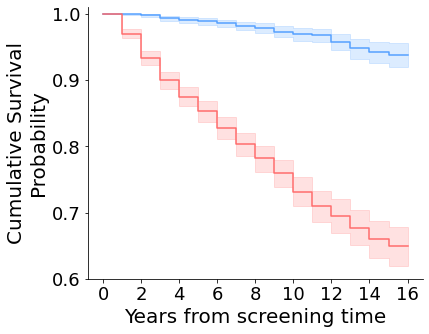

In [165]:
cause = 'all-cause' # 2-Malignant neoplasms
healthy_surv_prob_res = pickle.load(open('./result/paper_figures/nhanes_GeoValidation_'+cause+'_healthy_surv_prob_res.pkl', 'rb'))
unhealthy_surv_prob_res = pickle.load(open('./result/paper_figures/nhanes_GeoValidation_'+cause+'_unhealthy_surv_prob_res.pkl', 'rb'))
survival_probability_plot(healthy_surv_prob_res, unhealthy_surv_prob_res, alpha=0.05, title='', fontsize=18, show=False, save_path='./result/paper_figures/NHANES_'+cause+'_survival_probability.pdf')

# feature elimination

In [158]:
mortality = 'all-cause'
path = './result/IMPACT_Age_missforest/feature_elimination_'+mortality+'/'

In [159]:
cindex_dict = pickle.load(open(path+"cindex_dict.pickle.dat", "rb"))
cindex_geo_dict = pickle.load(open(path+"cindex_geo_dict.pickle.dat", "rb"))
left_cindex_dict = pickle.load(open(path+"left_cindex_dict.pickle.dat", "rb"))
left_cindex_geo_dict = pickle.load(open(path+"left_cindex_geo_dict.pickle.dat", "rb"))
right_cindex_dict = pickle.load(open(path+"right_cindex_dict.pickle.dat", "rb"))
right_cindex_geo_dict = pickle.load(open(path+"right_cindex_geo_dict.pickle.dat", "rb"))

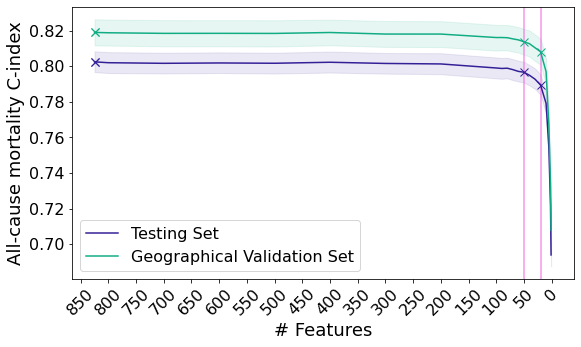

In [161]:
from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(50)
y_major_locator=MultipleLocator(0.02)

fontsize=18
plt.figure(figsize=(9,5))
plt.xlabel("# Features", fontsize= fontsize)
plt.ylabel("All-cause mortality C-index", fontsize= fontsize)
plt.xticks(fontsize=fontsize-2, rotation=45)
plt.yticks(fontsize=fontsize-2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

# Visualize the result
plt.axvline(x=50, color='#f368e0', alpha=0.7)
plt.axvline(x=20, color='#f368e0', alpha=0.7)

plt.plot(list(cindex_dict.keys()), [np.mean(cindex_dict[i]) for i in cindex_dict], color='#341f97',label='Testing Set')
plt.fill_between(list(cindex_dict.keys()), [left_cindex_dict[i] for i in left_cindex_dict], [right_cindex_dict[i] for i in right_cindex_dict],
                 color='#341f97', alpha=0.1)
plt.plot([list(cindex_dict.keys())[0], 50], [np.mean(cindex_dict[list(cindex_dict.keys())[0]]), np.mean(cindex_dict[50])], color='#341f97', marker='x', markersize=8, linestyle='None')
plt.plot([list(cindex_dict.keys())[0], 20], [np.mean(cindex_dict[list(cindex_dict.keys())[0]]), np.mean(cindex_dict[20])], color='#341f97', marker='x', markersize=8, linestyle='None')
# plt.axvline(x=list(auc_dict.keys())[0], ymax=0.81, color='blue', alpha=0.5, linestyle='dashed')


plt.plot(list(cindex_geo_dict.keys()), [np.mean(cindex_geo_dict[i]) for i in cindex_geo_dict], color='#10ac84',label='Geographical Validation Set')
plt.fill_between(list(cindex_geo_dict.keys()), [left_cindex_geo_dict[i] for i in left_cindex_geo_dict], [right_cindex_geo_dict[i] for i in right_cindex_geo_dict],
                 color='#10ac84', alpha=0.1)
plt.plot([list(cindex_geo_dict.keys())[0], 50], [np.mean(cindex_geo_dict[list(cindex_geo_dict.keys())[0]]), np.mean(cindex_geo_dict[50])], color='#10ac84', marker='x', markersize=8, linestyle='None')
plt.plot([list(cindex_geo_dict.keys())[0], 20], [np.mean(cindex_geo_dict[list(cindex_geo_dict.keys())[0]]), np.mean(cindex_geo_dict[20])], color='#10ac84', marker='x', markersize=8, linestyle='None')
# plt.axvline(x=list(auc_dict.keys())[0], ymax=0.81, color='blue', alpha=0.5, linestyle='dashed')

# ymin, ymax = plt.ylim()
# ymin=0.83
# plt.vlines(x=list(auc_dict.keys())[0], ymax=np.mean(auc_dict[list(auc_dict.keys())[0]]), ymin=ymin, color='blue', alpha=0.5, linestyle='dashed')
# plt.vlines(x=list(auc_dict_D_L.keys())[0], ymax=np.mean(auc_dict_D_L[list(auc_dict_D_L.keys())[0]]), ymin=ymin, color='green', alpha=0.5, linestyle='dashed')
# plt.vlines(x=list(auc_dict_D_Q_E.keys())[0], ymax=np.mean(auc_dict_D_Q_E[list(auc_dict_D_Q_E.keys())[0]]), ymin=ymin, color='orangered', alpha=0.5, linestyle='dashed')
plt.legend(loc=3, fontsize=fontsize-2)
plt.gca().invert_xaxis() 


save_file = './result/UKB_feature_elimination.pdf'
plt.savefig(save_file, format='pdf', bbox_inches='tight')

In [154]:
path = './NHANES/result/feature_elimination_all-cause/'

In [155]:
cindex_dict = pickle.load(open(path+"cindex_dict.pickle.dat", "rb"))
left_cindex_dict = pickle.load(open(path+"left_cindex_dict.pickle.dat", "rb"))
right_cindex_dict = pickle.load(open(path+"right_cindex_dict.pickle.dat", "rb"))

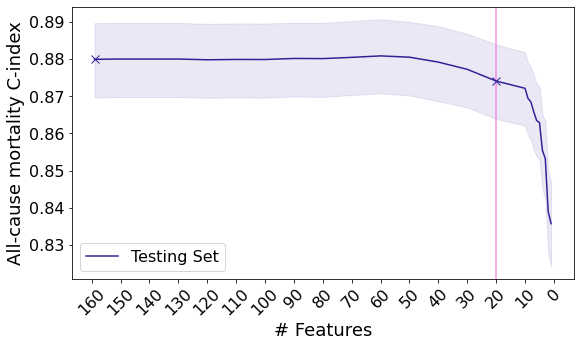

In [156]:
from matplotlib.pyplot import MultipleLocator
x_major_locator=MultipleLocator(10)
y_major_locator=MultipleLocator(0.01)

fontsize=18
plt.figure(figsize=(9,5))
plt.xlabel("# Features", fontsize= fontsize)
plt.ylabel("All-cause mortality C-index", fontsize= fontsize)
plt.xticks(fontsize=fontsize-2, rotation=45)
plt.yticks(fontsize=fontsize-2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

# Visualize the result
# plt.axvline(x=50, color='#f368e0', alpha=0.7)
plt.axvline(x=20, color='#f368e0', alpha=0.7)

plt.plot(list(cindex_dict.keys()), [np.mean(cindex_dict[i]) for i in cindex_dict], color='#341f97',label='Testing Set')
plt.fill_between(list(cindex_dict.keys()), [left_cindex_dict[i] for i in left_cindex_dict], [right_cindex_dict[i] for i in right_cindex_dict],
                 color='#341f97', alpha=0.1)
# plt.plot([list(cindex_dict.keys())[0], 50], [np.mean(cindex_dict[list(cindex_dict.keys())[0]]), np.mean(cindex_dict[50])], color='#341f97', marker='x', markersize=8, linestyle='None')
plt.plot([list(cindex_dict.keys())[0], 20], [np.mean(cindex_dict[list(cindex_dict.keys())[0]]), np.mean(cindex_dict[20])], color='#341f97', marker='x', markersize=8, linestyle='None')
# plt.axvline(x=list(auc_dict.keys())[0], ymax=0.81, color='blue', alpha=0.5, linestyle='dashed')


# ymin, ymax = plt.ylim()
# ymin=0.83
# plt.vlines(x=list(auc_dict.keys())[0], ymax=np.mean(auc_dict[list(auc_dict.keys())[0]]), ymin=ymin, color='blue', alpha=0.5, linestyle='dashed')
# plt.vlines(x=list(auc_dict_D_L.keys())[0], ymax=np.mean(auc_dict_D_L[list(auc_dict_D_L.keys())[0]]), ymin=ymin, color='green', alpha=0.5, linestyle='dashed')
# plt.vlines(x=list(auc_dict_D_Q_E.keys())[0], ymax=np.mean(auc_dict_D_Q_E[list(auc_dict_D_Q_E.keys())[0]]), ymin=ymin, color='orangered', alpha=0.5, linestyle='dashed')
plt.legend(loc=3, fontsize=fontsize-2)
plt.gca().invert_xaxis() 


save_file = './result/NHANES_feature_elimination.pdf'
plt.savefig(save_file, format='pdf', bbox_inches='tight')

# waterfall plot

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import sys; sys.path.insert(0,"/projects/leelab3/wqiu/shap")
import shap
import matplotlib.pylab as plt

In [2]:
features = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/features_initial_preprocessing_missforest_imputed_no_missing_lancet_and_meaningful_adjusted_assays_remove20002and20004_AgeAdjusted_CancerAdjusted.csv')
label_df = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/death_label.csv')
data_mortality = pd.merge(features, label_df[['eid', 'external']], how='left', on='eid')

In [3]:
age = 65
gender = 'female'
gender_index = 0
sample_rate = 0.3
age_feature = '21003-0.0'
gender_feature = '31-0.0'
X = data_mortality.copy()
if sample_rate<1:
    X = X.sample(n=int(sample_rate*len(X)), random_state=428)
X = X[(X[age_feature]>=39.5) & (X[age_feature]<=70.5)].reset_index(drop=True)  
X = X[(X['external']!=1)]
age_round = np.round(X[age_feature])
X = X[age_round==age]
if gender == 'female':
    X = X[X[gender_feature]==gender_index]
X_back, X_fore, _, _ = train_test_split(X, X, test_size=0.2, random_state=7)
X_fore = X_fore.reset_index(drop=True)  
X_back = X_back.reset_index(drop=True)  
print(X_back.shape)
print(X_fore.shape)

(2641, 833)
(661, 833)


In [4]:
shap_values_single_mean = pickle.load(open('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/shap_values_tasks_dict_'+gender+'_'+str(age)+'.pkl', 'rb'))
shap_values_single_rescaled = pickle.load(open('/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_decomposed_all-cause_EXPECT_age/shap_values_tasks_rescaled_dict_'+gender+'_'+str(age)+'.pkl', 'rb'))

In [5]:
t = 'all-cause'
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+t+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test/'
model_train = pickle.load(open(path+'/model.pickle.dat', "rb"))
shap_age_obj = pickle.load(open(path+'/different_age_background/'+gender+'/SHAP_age_exponential/shap_age_object.pkl', "rb"))
X_back = X_back[model_train.get_booster().feature_names]
X_fore = X_fore[model_train.get_booster().feature_names]
mortality_pre_back = model_train.predict(X_back.loc[X_back[gender_feature]==gender_index, :], output_margin=True)
mortality_pre_fore = model_train.predict(X_fore.loc[X_fore[gender_feature]==gender_index, :], output_margin=True)
expect_age_back = shap_age_obj.get_shap_age(mortality_pre_back)
expect_age_fore = shap_age_obj.get_shap_age(mortality_pre_fore)
explainer_all_cause = shap.TreeExplainer(model_train, data=X_back)

Passing 2641 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


In [6]:
def convert_shap_values_SameAge(shap_age_obj, shap_values_all_dict, fore_prediction, back_prediction):
    print('Starting converting SHAP values')
    fore_attr_defa = shap_values_all_dict.mean(2)
    fore_attr_per_ref = shap_values_all_dict
    fore_attr_per_ref = np.swapaxes(fore_attr_per_ref,1,2)                           # Re-order axes 
    fore_lodd_pred = fore_prediction
    back_lodd_pred = back_prediction

    fore_func_pred = shap_age_obj.get_shap_age(fore_lodd_pred)
    back_func_pred = shap_age_obj.get_shap_age(back_lodd_pred)
    fore_shap_age = fore_func_pred
    back_shap_age = back_func_pred
    # Get the factor by which we rescale the per back_data_temp attributions
    denom    = fore_lodd_pred[:,None] - back_lodd_pred[None,:]
    numer    = fore_func_pred[:,None] - back_func_pred[None,:]
    safe_div = lambda a,b : np.divide(a, b, out=np.zeros_like(a), where=b!=0) # Divide by zero gives zero
    rescale  = safe_div(numer, denom)        # Rescale factor based on func_lodds
    # Do the final rescaling
    final_attr = fore_attr_per_ref * rescale[:,:,None] # The final, rescaled attribution
    fore_final_attr = final_attr.mean(1)
    return fore_final_attr

In [7]:
file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in X_fore.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

In [8]:
for col in col_dict:
    if 'Age at cancer' in col_dict[col]:
        print(col)

40008-0.0
40008-0.0_1


In [9]:
X_fore[X_fore['40008-0.0']!=-1].index

Int64Index([  1,   7,   8,  12,  14,  18,  32,  39,  41,  44,  51,  52,  53,
             56,  63,  67,  68,  70,  77,  89,  94,  99, 100, 103, 107, 112,
            120, 124, 148, 155, 159, 163, 172, 175, 180, 187, 193, 199, 209,
            215, 224, 242, 252, 257, 259, 275, 281, 285, 296, 303, 313, 332,
            338, 345, 346, 348, 359, 386, 387, 396, 401, 420, 422, 423, 426,
            447, 448, 457, 464, 467, 472, 478, 480, 488, 490, 508, 527, 531,
            535, 539, 550, 560, 561, 565, 582, 584, 586, 598, 603, 621, 622,
            635, 639, 647, 656, 659],
           dtype='int64')

In [10]:
X_fore[X_fore['40008-0.0']!=-1].index

Int64Index([  1,   7,   8,  12,  14,  18,  32,  39,  41,  44,  51,  52,  53,
             56,  63,  67,  68,  70,  77,  89,  94,  99, 100, 103, 107, 112,
            120, 124, 148, 155, 159, 163, 172, 175, 180, 187, 193, 199, 209,
            215, 224, 242, 252, 257, 259, 275, 281, 285, 296, 303, 313, 332,
            338, 345, 346, 348, 359, 386, 387, 396, 401, 420, 422, 423, 426,
            447, 448, 457, 464, 467, 472, 478, 480, 488, 490, 508, 527, 531,
            535, 539, 550, 560, 561, 565, 582, 584, 586, 598, 603, 621, 622,
            635, 639, 647, 656, 659],
           dtype='int64')

In [11]:
i = 656
# 65:
# concept_figure: 656, 647, 38, 8, 490
# good: 283, 38
# medium: 258, 81, 38, 10, 36
# bad: 647, 656, 8, 18, 32, 490
explainer_all_cause = shap.TreeExplainer(model_train, data=X_back)
shap_values_all_cause = explainer_all_cause.shap_values(X_fore.loc[[i], :], per_reference=True)

In [12]:
shap_values_all_cause_rescaled = convert_shap_values_SameAge(shap_age_obj, shap_values_all_cause, mortality_pre_fore[i].reshape(-1), mortality_pre_back)

Starting converting SHAP values


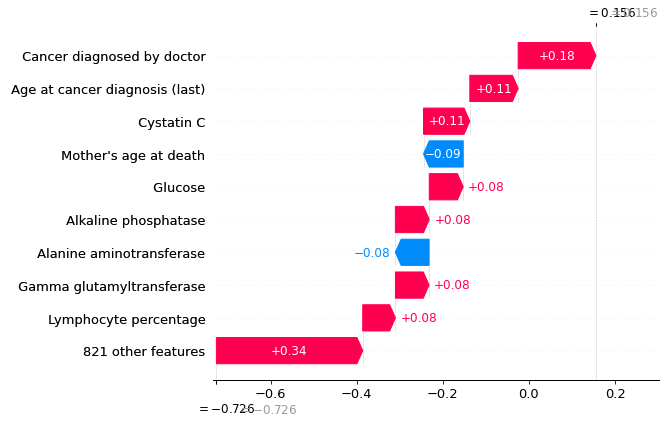

In [13]:
shap.waterfall_plot(explainer_all_cause.expected_value, shap_values_single_mean['all-cause'][i], features=X_fore.loc[i, :], feature_names=display_col, show=True)

72.50571


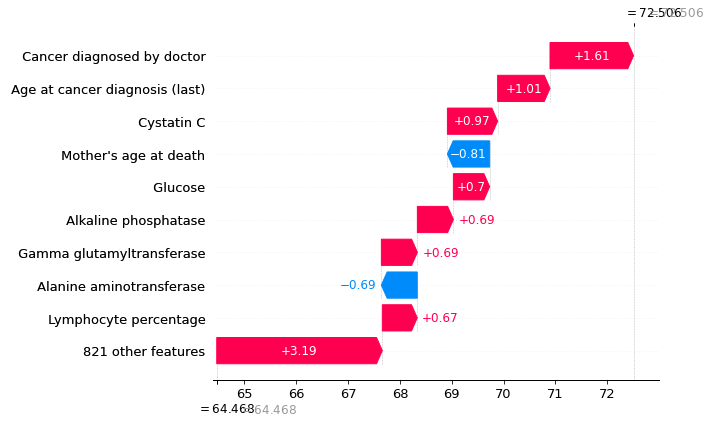

In [14]:
print(expect_age_fore[i])
fig = shap.waterfall_plot(expect_age_back.mean(), shap_values_all_cause_rescaled[0], features=X_fore.loc[i, :], feature_names=display_col, max_display=10, show=False)

In [18]:
# fig.savefig('./result/paper_figures/concept_waterfall_'+gender+'_'+str(age)+'_'+str(i)+'.pdf', format='pdf', bbox_inches='tight')
for ax in fig.axes:
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    for txt in ax.texts:
        txt.set_visible(False)
fig.savefig('./result/paper_figures/concept_waterfall_'+gender+'_'+str(age)+'_'+str(i)+'_LargeFont.png', format='png', transparent=True, dpi=300, bbox_inches='tight')

In [ ]:
for j in range(10):
    idx = np.argsort(-abs(shap_values_single_mean['all-cause'][i]))[j]
    print(display_col[idx])
    print(X_fore.iloc[i, idx])
    print(shap_values_single_mean['all-cause'][i][idx])